In [1]:
!pip install -Uqq git+https://github.com/jaysinghr/DL-to-Diffusion@develop
#!pip install nbdev

In [1]:
#|default_exp conv

# Convolutions

In [3]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from minimalai.training import *
from minimalai.datasets import *

In [4]:
import pickle, gzip, math, os, time, shutil
import torch
import matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [5]:
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
path_data = Path('/kaggle/input/mnist-data')
path_gz = path_data/'mnist.pkl'

with open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a *convolution*. A convolution requires nothing more than multiplication, and addition.

### Understanding the Convolution Equations

To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c).

Here's the input:

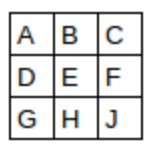

Here's our kernel:

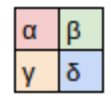

Since the filter fits in the image four times, we have four results:

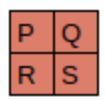

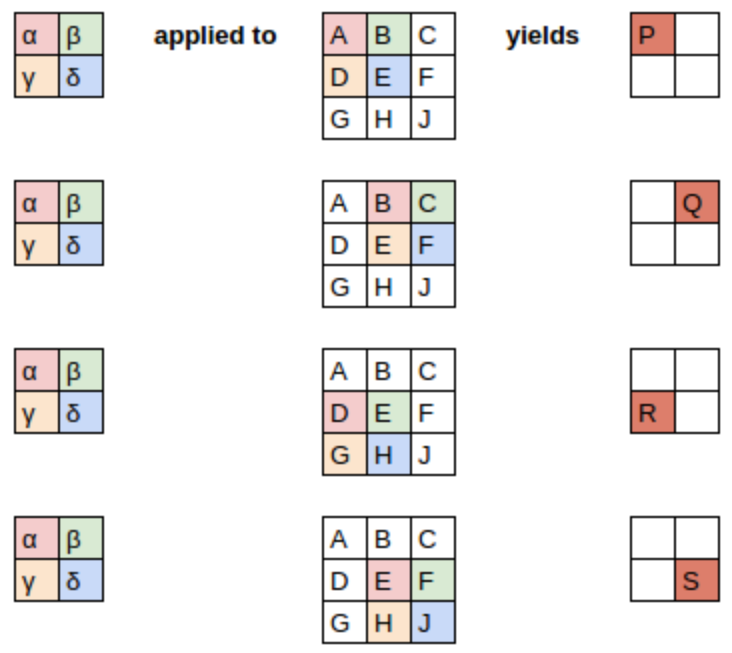

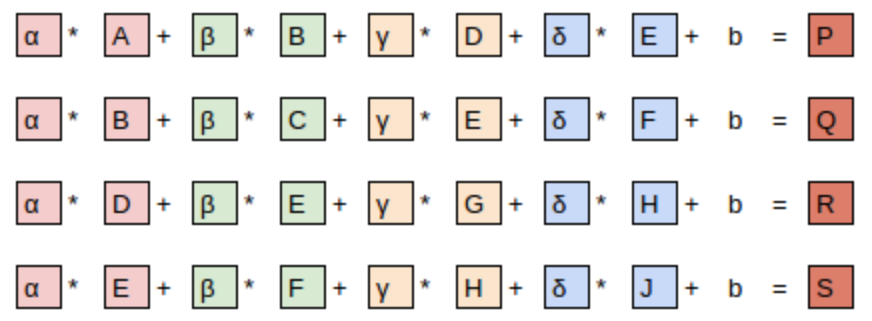

In [7]:
x_train.shape, x_valid.shape

(torch.Size([50000, 784]), torch.Size([10000, 784]))

In [8]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [9]:
x_imgs.shape, xv_imgs.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

In [10]:
mpl.rcParams['figure.dpi'] = 30

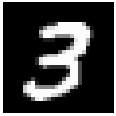

In [11]:
im3 = x_imgs[7]
show_image(im3);

### Let's find out top edge

In [12]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

We're going to call this our kernel (because that's what fancy computer vision researchers call these).

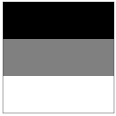

In [13]:
show_image(top_edge, noframe=False);

The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

$$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$$

it will return $-a1-a2-a3+a7+a8+a9$.

### Let's see top edge in an image of 3

In [14]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


The resulting value, 2.97 for the top edge and -2.95 for the bottom edge, represents the degree to which the filter matches the selected portion of the image. A higher positive value indicates a stronger match with the top edge, while a lower negative value indicates a stronger match with the bottom edge. This value helps in understanding how well the filter aligns with the features in the image.

In [15]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [16]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

By selecting a small portion of the image, applying a predefined filter designed to detect edges, and performing a mathematical operation, you can measure how well the filter matches the features in the image, which can help in understanding the presence and location of edges in the image.

In [17]:
def apply_kernel_to_image_region(row, col, kernel):
    """
    Apply a kernel to a region of an image and calculate the sum of element-wise products.

    Args:
    - image (numpy.ndarray): The input image as a numpy array.
    - row (int): The row index of the starting point for the image region.
    - col (int): The column index of the starting point for the image region.
    - kernel (numpy.ndarray): The kernel (filter) to apply to the image region.

    Returns:
    - float: The sum of element-wise products of the image region and the kernel.
    """
    # Select a 3x3 region of the image centered at (row, col)
    image_region = im3[row - 1 : row + 2, col - 1 : col + 2]

    # Apply the kernel to the image region and calculate the sum of element-wise products
    result = (image_region * kernel).sum()

    return result

In [18]:
apply_kernel_to_image_region(4, 15, top_edge)

tensor(2.9727)

In [19]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

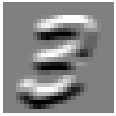

In [20]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel_to_image_region(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

### Let's find left edge

In [21]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

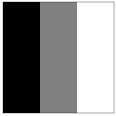

In [22]:
show_image(left_edge, noframe=False);

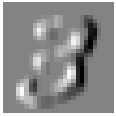

In [23]:
left_edge3 = tensor([[apply_kernel_to_image_region(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

<img alt="Result of applying a 3×3 kernel to a 4×4 image" width="782" caption="Result of applying a 3×3 kernel to a 4×4 image (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_ex_four_conv" src="attachment:209eb09b-e69f-4117-ac08-3b126bb40b3c.png">
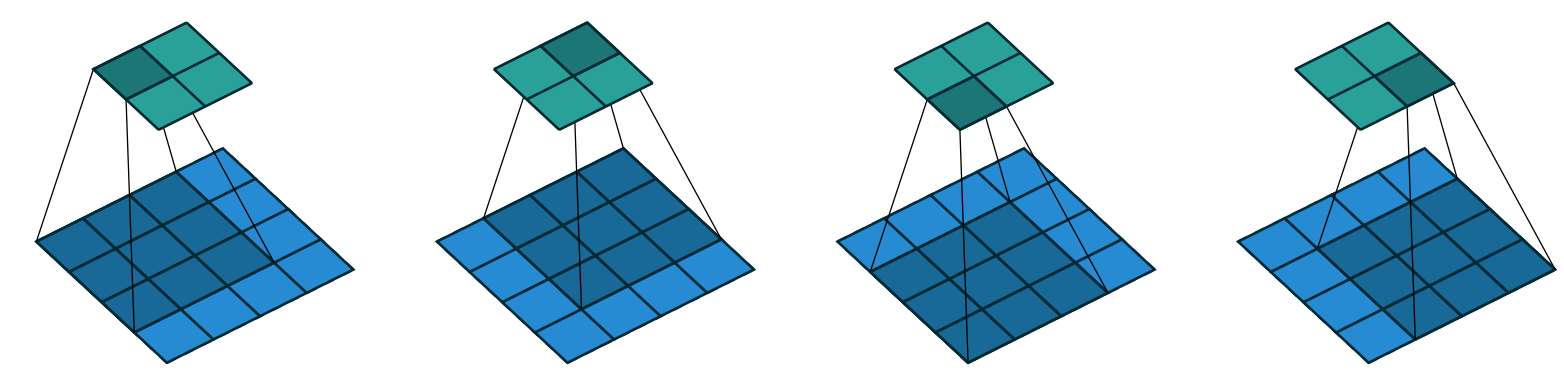

### Convolutions in PyTorch

In [24]:
import torch.nn.functional as F
import torch

What to do if you have [2 months to complete your thesis](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo)? Use [im2col](https://hal.inria.fr/inria-00112631/).

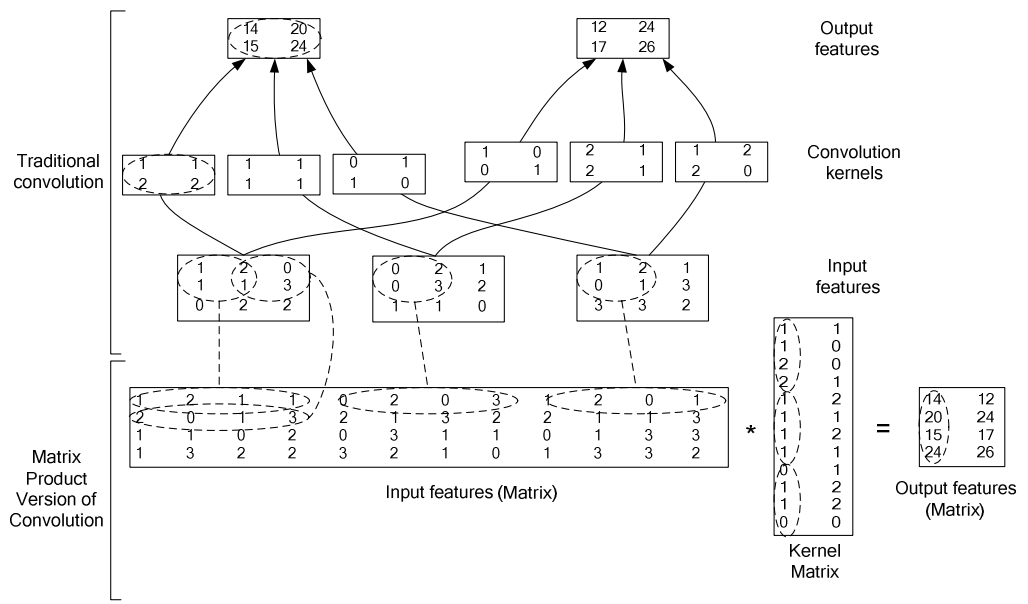

Here's a sample [numpy implementation](https://github.com/3outeille/CNNumpy/blob/5394f13e7ed67a808a3e39fd381f168825d65ff5/src/fast/utils.py#L360).

In [25]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

In [26]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [27]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

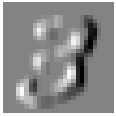

In [28]:
out = out_unf.view(26,26)
show_image(out);

In [29]:
%timeit -n 1 tensor([[apply_kernel_to_image_region(i,j,left_edge) for j in rng] for i in rng]);

11.2 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

55.5 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

The slowest run took 6.47 times longer than the fastest. This could mean that an intermediate result is being cached.
37.2 µs ± 39.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

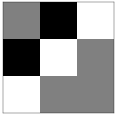

In [33]:
show_image(diag1_edge, noframe=False);

In [34]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

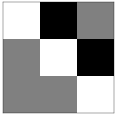

In [35]:
show_image(diag2_edge, noframe=False);

In [36]:
x_imgs[:16].shape

torch.Size([16, 28, 28])

In [37]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [38]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [39]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

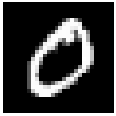

In [40]:
img0 = xb[1,0]
show_image(img0);

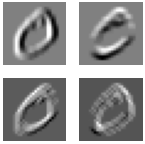

In [41]:
show_images([batch_features[1,i] for i in range(4)])

### Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image.

<img src="images/chapter9_padconv.svg" id="pad_conv" caption="A convolution with padding" alt="A convolution with padding" width="600">

With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="783" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="images/att_00029.png">

If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`.

We could move over two pixels after each kernel application. This is known as a *stride-2* convolution.

<img alt="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding" width="774" caption="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_by_five_conv" src="images/att_00030.png">

## Creating the CNN

In [42]:
# Get the shape of the input data (number of samples and number of features)
num_samples, num_features = x_train.shape

# Calculate the number of classes in the target labels
num_classes = y_train.max() + 1

# Set the number of hidden units for a neural network layer
num_hidden_units = 50


In [43]:
model = nn.Sequential(nn.Linear(num_features, num_hidden_units), nn.ReLU(), nn.Linear(num_hidden_units, 10))

In [44]:
# Define a convolutional neural network (CNN) model using nn.Sequential
broken_cnn_model = nn.Sequential(
    # First convolutional layer: 1 input channel, 30 output channels, 3x3 kernel size, 1 padding
    nn.Conv2d(in_channels=1, out_channels=30, kernel_size=3, padding=1),
    nn.ReLU(),  # ReLU activation function
    # Second convolutional layer: 30 input channels, 10 output channels, 3x3 kernel size, 1 padding
    nn.Conv2d(in_channels=30, out_channels=10, kernel_size=3, padding=1)
)


In [45]:
broken_cnn_model(xb).shape

torch.Size([16, 10, 28, 28])

In [46]:
#|export
def conv_layer(input_channels, output_channels, kernel_size=3, stride=2, apply_activation=True):
    """
    Create a convolutional layer with optional activation.

    Args:
    - input_channels (int): Number of input channels for the convolutional layer.
    - output_channels (int): Number of output channels (filters) for the convolutional layer.
    - kernel_size (int): Size of the convolutional kernel (filter) (default: 3).
    - stride (int): Stride of the convolution operation (default: 2).
    - apply_activation (bool): Whether to apply ReLU activation after the convolution (default: True).

    Returns:
    - torch.nn.Module: The created convolutional layer (with optional activation).
    """
    # Create the convolutional layer with specified parameters
    conv_layer = nn.Conv2d(in_channels=input_channels, out_channels=output_channels,
                           kernel_size=kernel_size, stride=stride, padding=kernel_size//2)
    
    # Apply ReLU activation if specified
    if apply_activation:
        conv_layer = nn.Sequential(conv_layer, nn.ReLU())
    
    return conv_layer


Refactoring parts of your neural networks like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

In [47]:
"""
Create a simple convolutional neural network (CNN) model for image classification.
The CNN consists of multiple convolutional layers followed by a flattening layer.

Returns:
- torch.nn.Module: The created simple CNN model.
"""
# Define the layers of the simple CNN using nn.Sequential
simple_cnn_model = nn.Sequential(
    # First convolutional layer: 1 input channel, 4 output channels, 3x3 kernel size, stride 1, padding 1
    conv_layer(input_channels=1, output_channels=4),    #14*14
    # ReLU activation function
    nn.ReLU(),
    # Second convolutional layer: 4 input channels, 8 output channels, 3x3 kernel size, stride 1, padding 1
    conv_layer(input_channels=4, output_channels=8),    #7*7
    # ReLU activation function
    nn.ReLU(),
    # Third convolutional layer: 8 input channels, 16 output channels, 3x3 kernel size, stride 1, padding 1
    conv_layer(input_channels=8, output_channels=16),    #4*4
    # ReLU activation function
    nn.ReLU(),
    # Fourth convolutional layer: 16 input channels, 16 output channels, 3x3 kernel size, stride 1, padding 1
    conv_layer(input_channels=16, output_channels=16),    #2*2
    # ReLU activation function
    nn.ReLU(),
    # Fifth convolutional layer: 16 input channels, 10 output channels, 3x3 kernel size, stride 1, padding 1
    # No activation function applied after this layer
    conv_layer(input_channels=16, output_channels=10, apply_activation=False),    #1*1
    # Flatten layer to flatten the output for the final classification layer
    nn.Flatten(),
)

In [48]:
simple_cnn_model(xb).shape

torch.Size([16, 10])

In [49]:
# Reshaping to (num_samples, 1, 28, 28) to represent images with 1 channel and size 28x28
x_train_images = x_train.view(-1, 1, 28, 28)
x_valid_images = x_valid.view(-1, 1, 28, 28)

# Create training and validation datasets using the prepared input images and target labels
# Each dataset contains pairs of input images and target labels
train_dataset = Dataset(x_train_images, y_train)
valid_dataset = Dataset(x_valid_images, y_valid)

In [50]:
#|export
# Determine the default device based on availability (mps, cuda, cpu)
default_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def move_data_to_device(data, device=default_device):
    """
    Move input data tensors or nested collections of tensors to the specified device.

    Args:
    - data (torch.Tensor or Mapping or Iterable): Input data tensors or nested collections of tensors.
    - device (str): Target device to move the data to (default: determined based on availability).

    Returns:
    - torch.Tensor or Mapping or Iterable: Data tensors or nested collections of tensors moved to the specified device.
    """
    # If input is a single tensor, move it to the specified device
    if isinstance(data, torch.Tensor):
        return data.to(device)
    # If input is a mapping (e.g., dictionary), move each value to the specified device
    if isinstance(data, Mapping):
        return {key: value.to(device) for key, value in data.items()}
    # If input is an iterable (e.g., list), recursively move each element to the specified device
    return type(data)(move_data_to_device(item, device) for item in data)

def collate_data_on_device(batch, device=default_device):
    """
    Collate a batch of data and move it to the specified device.

    Args:
    - batch (Iterable): Batch of data to collate.
    - device (str): Target device to move the collated batch to (default: determined based on availability).

    Returns:
    - torch.Tensor or Mapping or Iterable: Collated batch of data moved to the specified device.
    """
    # Collate the batch of data and move it to the specified device
    return move_data_to_device(default_collate(batch), device)

In [51]:
import torch.optim as optim

# Define batch size and learning rate
batch_size = 256
learning_rate = 0.4

# Create training and validation data loaders using the prepared datasets
train_data_loader, valid_data_loader = get_dataloaders(train_dataset, valid_dataset, batch_size, collate_fn=collate_data_on_device)

# Initialize the optimizer with the parameters of the simple CNN model and the specified learning rate
optimizer = optim.SGD(simple_cnn_model.parameters(), lr=learning_rate)

In [53]:
# Train the simple CNN model for 5 epochs using the specified optimizer, loss function, and data loaders
# The `fit` function typically iterates over the specified number of epochs and updates the model parameters
# It computes the loss and accuracy for each epoch based on the training and validation data
# Finally, it returns the loss and accuracy metrics for the trained model
loss, accuracy = fit(num_epochs=5,
                     model=simple_cnn_model.to(default_device),  # Move the model to the default device
                     loss_function=F.cross_entropy,  # Cross-entropy loss function
                     optimizer=optimizer,  # Optimizer used for training (e.g., SGD)
                     train_loader=train_data_loader,  # Training data loader
                     validation_loader=valid_data_loader)  # Validation data loader




Epoch 1, Total Loss: 0.3271063087940216, Total Accuracy: 0.8896999995231628
Epoch 2, Total Loss: 0.3251189736843109, Total Accuracy: 0.901800000667572
Epoch 3, Total Loss: 0.11218939118385315, Total Accuracy: 0.9670999992370606
Epoch 4, Total Loss: 0.11345831854343415, Total Accuracy: 0.9663999993324279
Epoch 5, Total Loss: 0.10047257430553436, Total Accuracy: 0.970899999332428


In [56]:
# Define the learning rate and create an optimizer with a learning rate lr/4
learning_rate = learning_rate / 4
optimizer = optim.SGD(simple_cnn_model.parameters(), lr=learning_rate)

# Train the simple CNN model for 5 epochs using the specified optimizer, loss function, and data loaders
# Assuming the `fit` function is defined elsewhere and performs the training loop
# The `fit` function typically iterates over the specified number of epochs and updates the model parameters
# It computes the loss and accuracy for each epoch based on the training and validation data
# Finally, it returns the loss and accuracy metrics for the trained model
loss, accuracy = fit(num_epochs=5,
                     model=simple_cnn_model.to(default_device),  # Move the model to the default device
                     loss_function=F.cross_entropy,  # Cross-entropy loss function
                     optimizer=optimizer,  # Optimizer used for training (SGD with lr/4)
                     train_loader=train_data_loader,  # Training data loader
                     validation_loader=valid_data_loader)  # Validation data loader

Epoch 1, Total Loss: 0.07915056762695312, Total Accuracy: 0.9766999995231629
Epoch 2, Total Loss: 0.07885724818706512, Total Accuracy: 0.9769999996185302
Epoch 3, Total Loss: 0.07726738607883453, Total Accuracy: 0.9769999995231629
Epoch 4, Total Loss: 0.07634059710502625, Total Accuracy: 0.9769999995231629
Epoch 5, Total Loss: 0.07740628395080566, Total Accuracy: 0.9769999996185302


### Understanding Convolution Arithmetic

In an input of size `64x1x28x28` the axes are `batch,channel,height,width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the other hand, uses `NHWC` axis order (aka "channels-last"). Channels-last is faster for many models, so recently it's become more common to see this as an option in PyTorch too.

We have 1 input channel, 4 output channels, and a 3×3 kernel.

In [57]:
simple_cnn_model[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [58]:
conv1 = simple_cnn_model[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [59]:
conv1.bias.shape

torch.Size([4])

The *receptive field* is the area of an image that is involved in the calculation of a layer. *conv-example.xlsx* shows the calculation of two stride-2 convolutional layers using an MNIST digit. Here's what we see if we click on one of the cells in the *conv2* section, which shows the output of the second convolutional layer, and click *trace precedents*.

<img alt="Immediate precedents of conv2 layer" width="308" caption="Immediate precedents of Conv2 layer" id="preced1" src="images/att_00068.png">

The blue highlighted cells are its *precedents*—that is, the cells used to calculate its value. These cells are the corresponding 3×3 area of cells from the input layer (on the left), and the cells from the filter (on the right). Click *trace precedents* again:

<img alt="Secondary precedents of conv2 layer" width="601" caption="Secondary precedents of Conv2 layer" id="preced2" src="images/att_00069.png">

In this example, we have just two convolutional layers. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This is the *receptive field*

The deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer.

## Color Images

A colour picture is a rank-3 tensor:

In [60]:
from torchvision.io import read_image

In [62]:
im = read_image('/kaggle/input/images/grizzly.jpg')
im.shape

torch.Size([3, 1000, 846])

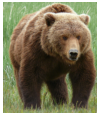

In [63]:
show_image(im.permute(1,2,0));

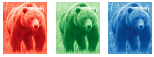

In [64]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): 
    show_image(255-bear, ax=ax, cmap=color)

<img src="images/chapter9_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

These are then all added together, to produce a single number, for each grid location, for each output feature.

<img src="images/chapter9_rgb_conv_stack.svg" id="rgbconv2" caption="Adding the RGB filters" alt="Adding the RGB filters" width="500">

We have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels.

## Export -

In [2]:
import nbdev; nbdev.nbdev_export()